In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.feature_selection import SelectFromModel

In [4]:
gold_df = pd.read_csv('FINAL_USO.csv', na_values = ['N/A'], index_col = 'Date', parse_dates = True, infer_datetime_format = True)
gold_df.head()

,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,SP_close,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-15,154.740005,154.949997,151.710007,152.330002,152.330002,21521900,123.029999,123.199997,121.989998,122.180000,...,51.570000,51.680000,48.973877,20605600,36.900002,36.939999,36.049999,36.130001,36.130001,12616700
2011-12-16,154.309998,155.369995,153.899994,155.229996,155.229996,18124300,122.230003,122.949997,121.300003,121.589996,...,52.040001,52.680000,49.921513,16285400,36.180000,36.500000,35.730000,36.270000,36.270000,12578800
2011-12-19,155.479996,155.860001,154.360001,154.869995,154.869995,12547200,122.059998,122.320000,120.029999,120.290001,...,51.029999,51.169998,48.490578,15120200,36.389999,36.450001,35.930000,36.200001,36.200001,7418200
2011-12-20,156.820007,157.429993,156.580002,156.979996,156.979996,9136300,122.180000,124.139999,120.370003,123.930000,...,52.369999,52.990002,50.215282,11644900,37.299999,37.610001,37.220001,37.560001,37.560001,10041600
2011-12-21,156.979996,157.529999,156.130005,157.160004,157.160004,11996100,123.930000,124.360001,122.750000,124.169998,...,52.419998,52.959999,50.186852,8724300,37.669998,38.240002,37.520000,38.110001,38.110001,10728000


In [5]:
gold_df.shape

(1718, 80)

In [6]:
gold_df.describe()

,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,SP_close,...,GDX_Low,GDX_Close,GDX_Adj Close,GDX_Volume,USO_Open,USO_High,USO_Low,USO_Close,USO_Adj Close,USO_Volume
count,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,1718.000000,...,1718.000000,1718.000000,1718.000000,1.718000e+03,1718.000000,1718.000000,1718.000000,1718.000000,1718.000000,1.718000e+03
mean,127.323434,127.854237,126.777695,127.319482,127.319482,8.446327e+06,204.490023,205.372637,203.487014,204.491222,...,26.384575,26.715012,25.924624,4.356515e+07,22.113417,22.307148,21.904657,22.109051,22.109051,1.922313e+07
std,17.526993,17.631189,17.396513,17.536269,17.536269,4.920731e+06,43.831928,43.974644,43.618940,43.776999,...,10.490908,10.603110,9.886570,2.909151e+07,11.431056,11.478671,11.373997,11.432787,11.432787,1.575743e+07
min,100.919998,100.989998,100.230003,100.500000,100.500000,1.501600e+06,122.059998,122.320000,120.029999,120.290001,...,12.400000,12.470000,12.269618,4.729000e+06,7.820000,8.030000,7.670000,7.960000,7.960000,1.035100e+06
25%,116.220001,116.540001,115.739998,116.052502,116.052502,5.412925e+06,170.392498,170.962505,169.577499,170.397500,...,20.355000,20.585000,20.180950,2.259968e+07,11.420000,11.500000,11.300000,11.392500,11.392500,6.229500e+06
50%,121.915001,122.325001,121.369999,121.795002,121.795002,7.483900e+06,205.464996,206.459999,204.430000,205.529999,...,22.870001,23.054999,22.677604,3.730465e+07,16.450000,16.635000,16.040000,16.345000,16.345000,1.613015e+07
75%,128.427494,129.087498,127.840001,128.470001,128.470001,1.020795e+07,237.292500,237.722500,236.147502,236.889996,...,26.797500,27.317500,26.478154,5.697055e+07,34.419998,34.667499,34.110000,34.417499,34.417499,2.672375e+07
max,173.199997,174.070007,172.919998,173.610001,173.610001,9.380420e+07,293.089996,293.940002,291.809998,293.579987,...,56.770000,57.470001,54.617039,2.321536e+08,41.599998,42.299999,41.299999,42.009998,42.009998,1.102657e+08


In [7]:
gold_df.isnull().sum()

Open             0
High             0
Low              0
Close            0
Adj Close        0
                ..
USO_High         0
USO_Low          0
USO_Close        0
USO_Adj Close    0
USO_Volume       0
Length: 80, dtype: int64

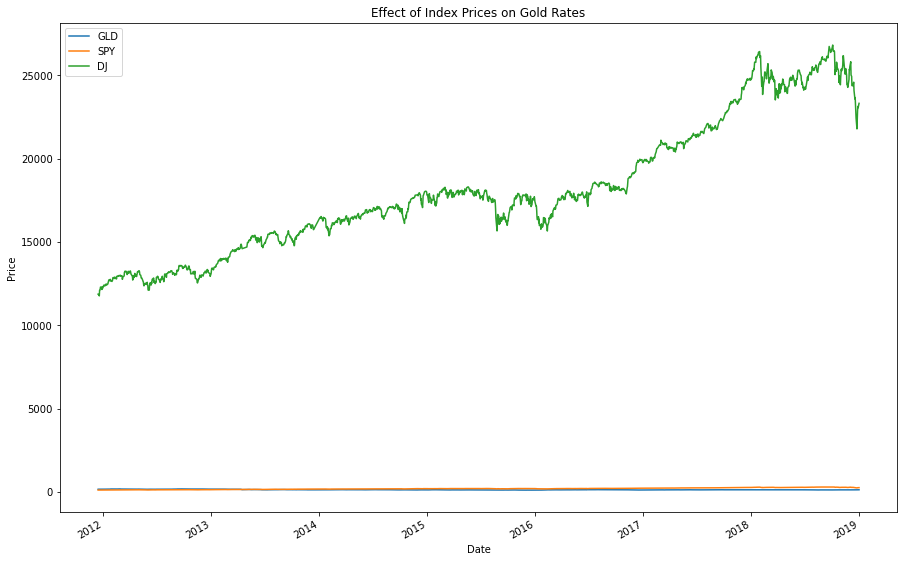

In [8]:
gld_adj_close = gold_df['Adj Close']
spy_adj_close = gold_df['SP_Ajclose']
dj_adj_close = gold_df['DJ_Ajclose']

gold_df_p = pd.DataFrame({'GLD': gld_adj_close, 'SPY': spy_adj_close, 'DJ': dj_adj_close})
gold_df_ax = gold_df_p.plot(title = 'Effect of Index Prices on Gold Rates', figsize = (15,10))
gold_df_ax.set_ylabel('Price')
gold_df_ax.legend(loc = 'upper left')
plt.show()


In [9]:
def calc_daily_returns(df): # calculate and return daily returns values
    daily_returns = (df / df.shift(1)) - 1
    daily_returns[0] = 0
    return daily_returns

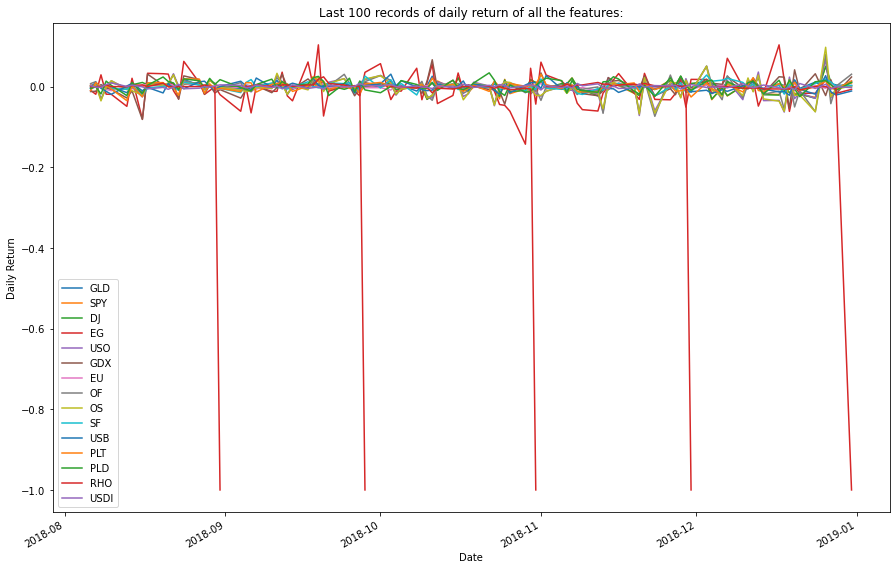

In [10]:
gld_adj_close = gold_df['Adj Close']
spy_adj_close = gold_df['SP_Ajclose']
dj_adj_close = gold_df['DJ_Ajclose']
eg_adj_close = gold_df['EG_Ajclose']
uso_adj_close = gold_df['USO_Adj Close']
gdx_adj_close = gold_df['GDX_Adj Close']
eu_price = gold_df['EU_Price']
of_price = gold_df['OF_Price']
os_price = gold_df['OS_Price']
sf_price = gold_df['SF_Price']
usb_price = gold_df['USB_Price']
plt_price = gold_df['PLT_Price']
pld_price = gold_df['PLD_Price']
rho_price = gold_df['RHO_PRICE']
usdi_price = gold_df['USDI_Price']

gld_daily_returns = calc_daily_returns(gld_adj_close)
spy_daily_returns = calc_daily_returns(spy_adj_close)
dj_adj_returns = calc_daily_returns(dj_adj_close)
eg_adj_returns = calc_daily_returns(eg_adj_close)
uso_adj_returns = calc_daily_returns(uso_adj_close)
gdx_adj_returns = calc_daily_returns(gdx_adj_close)
eu_returns = calc_daily_returns(eu_price)
of_returns = calc_daily_returns(of_price)
os_returns = calc_daily_returns(os_price)
sf_returns = calc_daily_returns(sf_price)
usb_returns = calc_daily_returns(usb_price)
plt_returns = calc_daily_returns(plt_price)
pld_returns = calc_daily_returns(pld_price)
rho_returns = calc_daily_returns(rho_price)
usdi_returns = calc_daily_returns(usdi_price)

gold_df_d = pd.DataFrame({'GLD': gld_daily_returns, 'SPY': spy_daily_returns, 'DJ': dj_adj_returns, 'EG': eg_adj_returns, 'USO': uso_adj_returns, 'GDX': gdx_adj_returns, 'EU': eu_returns, 'OF': of_returns, 'OS': os_returns, 'SF': sf_returns, 'USB': usb_returns, 'PLT': plt_returns, 'PLD': pld_returns, 'RHO': rho_returns, 'USDI': usdi_returns})
gold_daily_ax = gold_df_d[-100:].plot(title = 'Last 100 records of daily return of all the features:', figsize = (15,10))
gold_daily_ax.set_ylabel('Daily Return')
gold_daily_ax.legend(loc = 'lower left')

plt.show()

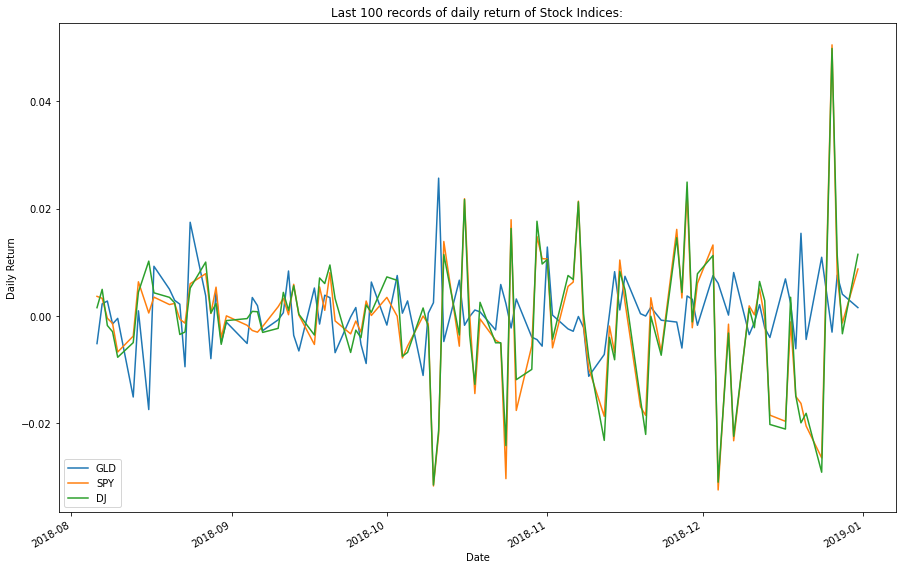

In [12]:
gold_df_s = pd.DataFrame({'GLD': gld_daily_returns, 'SPY': spy_daily_returns, 'DJ': dj_adj_returns})
gold_daily_ax = gold_df_s[-100:].plot(title = 'Last 100 records of daily return of Stock Indices:', figsize = (15,10))
gold_daily_ax.set_ylabel('Daily Return')
gold_daily_ax.legend(loc = 'lower left')

plt.show()

<AxesSubplot:xlabel='USDI', ylabel='GLD'>

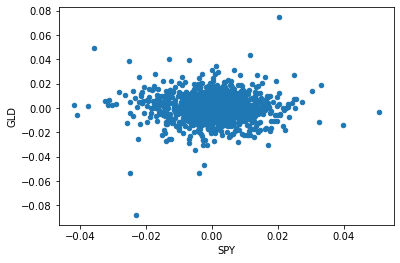

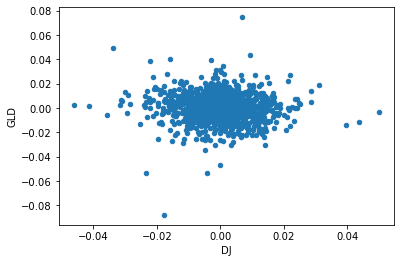

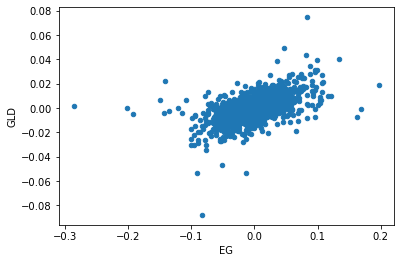

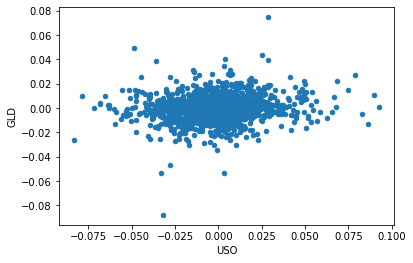

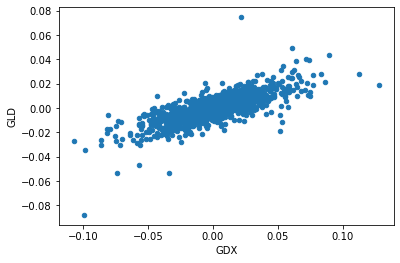

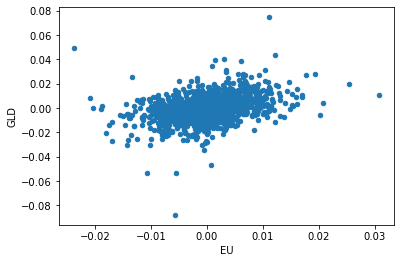

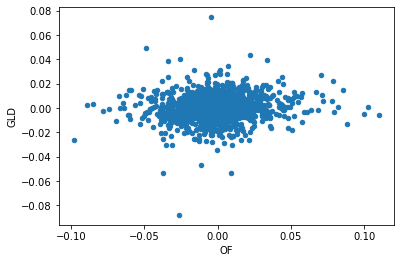

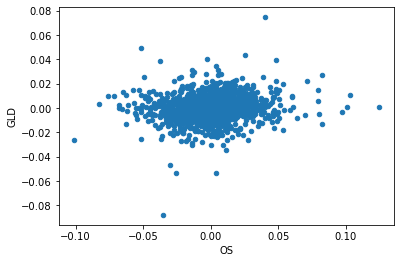

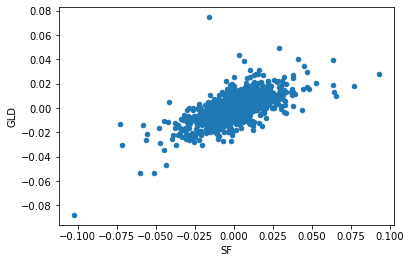

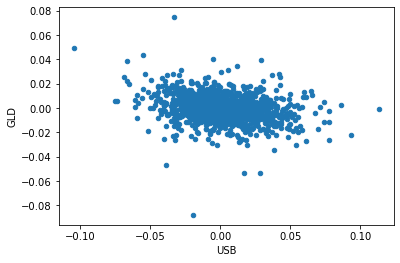

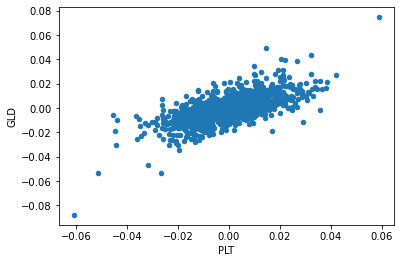

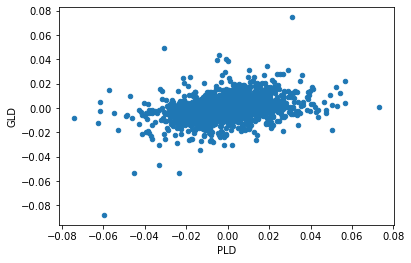

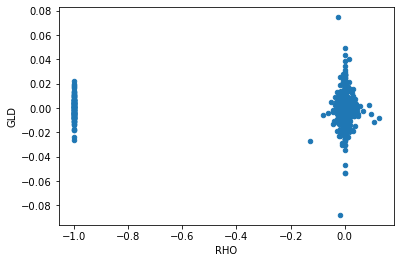

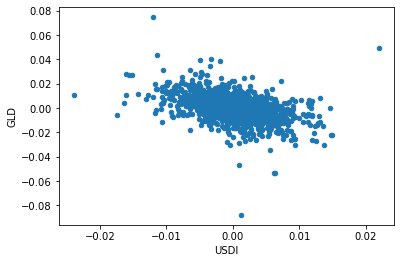

In [13]:
gold_df_d.plot(kind = 'scatter', x = 'SPY', y = 'GLD')
gold_df_d.plot(kind = 'scatter', x = 'DJ', y = 'GLD')
gold_df_d.plot(kind = 'scatter', x = 'EG', y = 'GLD')
gold_df_d.plot(kind = 'scatter', x = 'USO', y = 'GLD')
gold_df_d.plot(kind = 'scatter', x = 'GDX', y = 'GLD')
gold_df_d.plot(kind = 'scatter', x = 'EU', y = 'GLD')
gold_df_d.plot(kind = 'scatter', x = 'OF', y = 'GLD')
gold_df_d.plot(kind = 'scatter', x = 'OS', y = 'GLD')
gold_df_d.plot(kind = 'scatter', x = 'SF', y = 'GLD')
gold_df_d.plot(kind = 'scatter', x = 'USB', y = 'GLD')
gold_df_d.plot(kind = 'scatter', x = 'PLT', y = 'GLD')
gold_df_d.plot(kind = 'scatter', x = 'PLD', y = 'GLD')
gold_df_d.plot(kind = 'scatter', x = 'RHO', y = 'GLD')
gold_df_d.plot(kind = 'scatter', x = 'USDI', y = 'GLD')

Mean =  -8.656986121282088e-05
Standard deviation =  0.009611536167006387
Kurtosis =  8.606584924918355


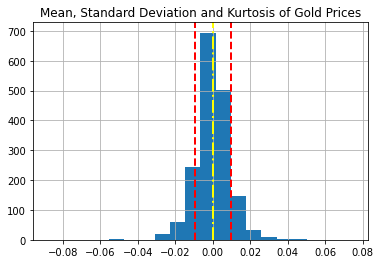

<Figure size 1080x576 with 0 Axes>

In [23]:
gold_mean = gold_df_d['GLD'].mean() #calculating mean gold price
gold_std = gold_df_d['GLD'].std() # calculating standard deviation
gold_kurt = gold_df_d['GLD'].kurtosis() # calculating kurtosis value

print('Mean = ', gold_mean)
print('Standard deviation = ', gold_std)
print('Kurtosis = ', gold_kurt)

gold_df_d['GLD'].hist(bins = 20) # plotting histogram

plt.axvline(gold_mean, color = 'yellow', linestyle = '-.', linewidth = 2)
plt.axvline(gold_std, color = 'red', linestyle = '--', linewidth = 2)
plt.axvline(-gold_std, color = 'red', linestyle = '--', linewidth = 2)
plt.title('Mean, Standard Deviation and Kurtosis of Gold Prices')
plt.figure(figsize = (15,8))

plt.show()

Mean =  0.0005366024364688843
Standard deviation =  0.008262309911393529
Kurtosis =  3.455785903974527


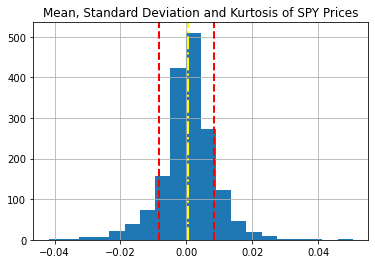

<Figure size 1080x576 with 0 Axes>

In [14]:
gold_sp_mean = gold_df_d['SPY'].mean() # computing mean of gold stock
gold_sp_std = gold_df_d['SPY'].std() # computing standard deviation of gold stock
gold_sp_kurt = gold_df_d['SPY'].kurtosis() # computing kurtosis of gold stock

print('Mean = ', gold_sp_mean)
print('Standard deviation = ', gold_sp_std)
print('Kurtosis = ', gold_sp_kurt)

gold_df_d['SPY'].hist(bins = 20) # plotting histogram

plt.axvline(gold_sp_mean, color = 'yellow', linestyle = '-.', linewidth = 2)
plt.axvline(gold_sp_std, color = 'red', linestyle = '--', linewidth = 2)
plt.axvline(-gold_sp_std, color = 'red', linestyle = '--', linewidth = 2)
plt.title('Mean, Standard Deviation and Kurtosis of SPY Prices')
plt.figure(figsize = (15,8))

plt.show()

Mean =  0.00042663952187518107
Standard deviation =  0.008151780114512312
Kurtosis =  3.8327193362606957


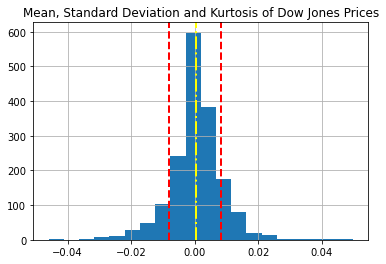

<Figure size 1080x576 with 0 Axes>

In [15]:
gold_dj_mean = gold_df_d['DJ'].mean() # computing mean of gold stock
gold_dj_std = gold_df_d['DJ'].std() # computing standard deviation of gold stock
gold_dj_kurt = gold_df_d['DJ'].kurtosis() # computing kurtosis of gold stock

print('Mean = ', gold_dj_mean)
print('Standard deviation = ', gold_dj_std)
print('Kurtosis = ', gold_dj_kurt)

gold_df_d['DJ'].hist(bins = 20) # plotting histogram

plt.axvline(gold_dj_mean, color = 'yellow', linestyle = '-.', linewidth = 2)
plt.axvline(gold_dj_std, color = 'red', linestyle = '--', linewidth = 2)
plt.axvline(-gold_dj_std, color = 'red', linestyle = '--', linewidth = 2)
plt.title('Mean, Standard Deviation and Kurtosis of Dow Jones Prices')
plt.figure(figsize = (15,8))

plt.show()

<AxesSubplot:>

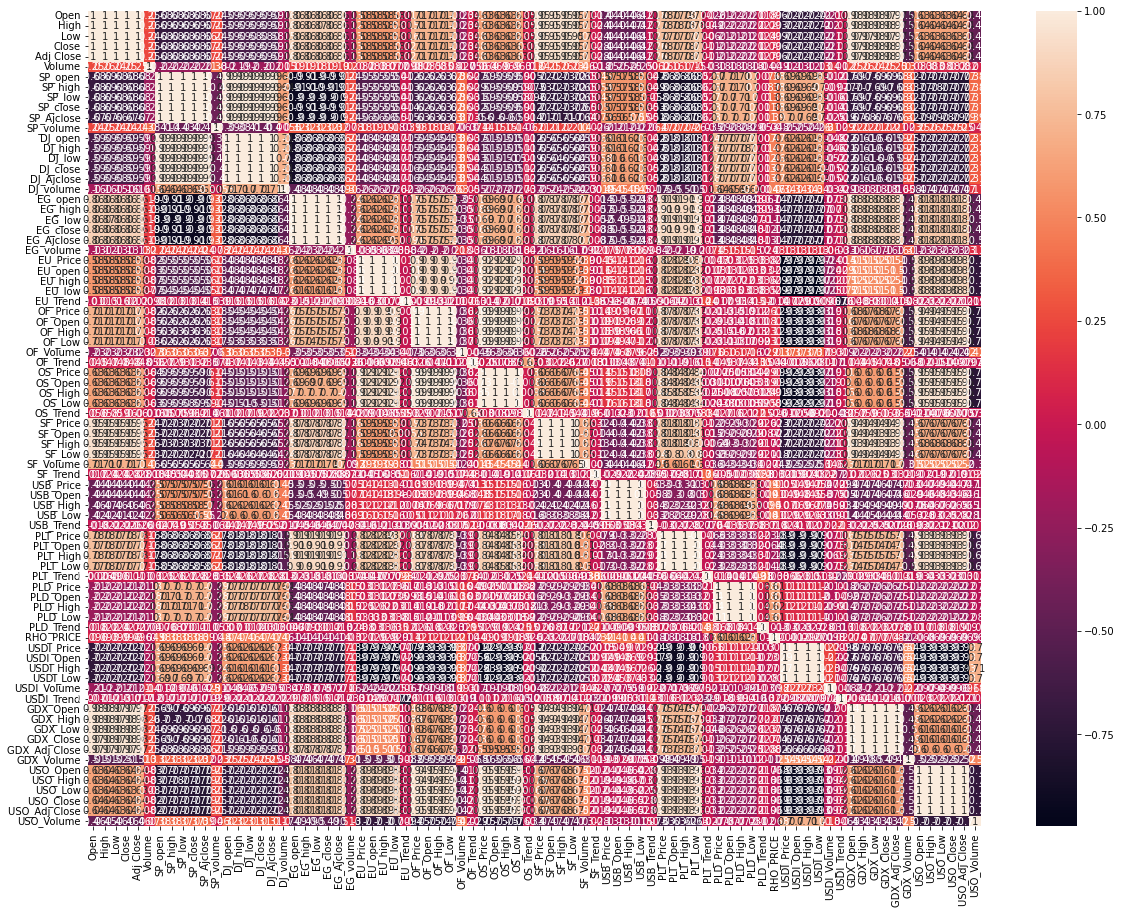

In [16]:
plt.figure(figsize = (20,15))
sns.heatmap(gold_df.corr(), annot = True)

In [17]:
X = gold_df.drop(['Adj Close'], axis = 1)
X = X.drop(['Close'], axis = 1)

<AxesSubplot:title={'center':'Correlation with Adj Close'}>

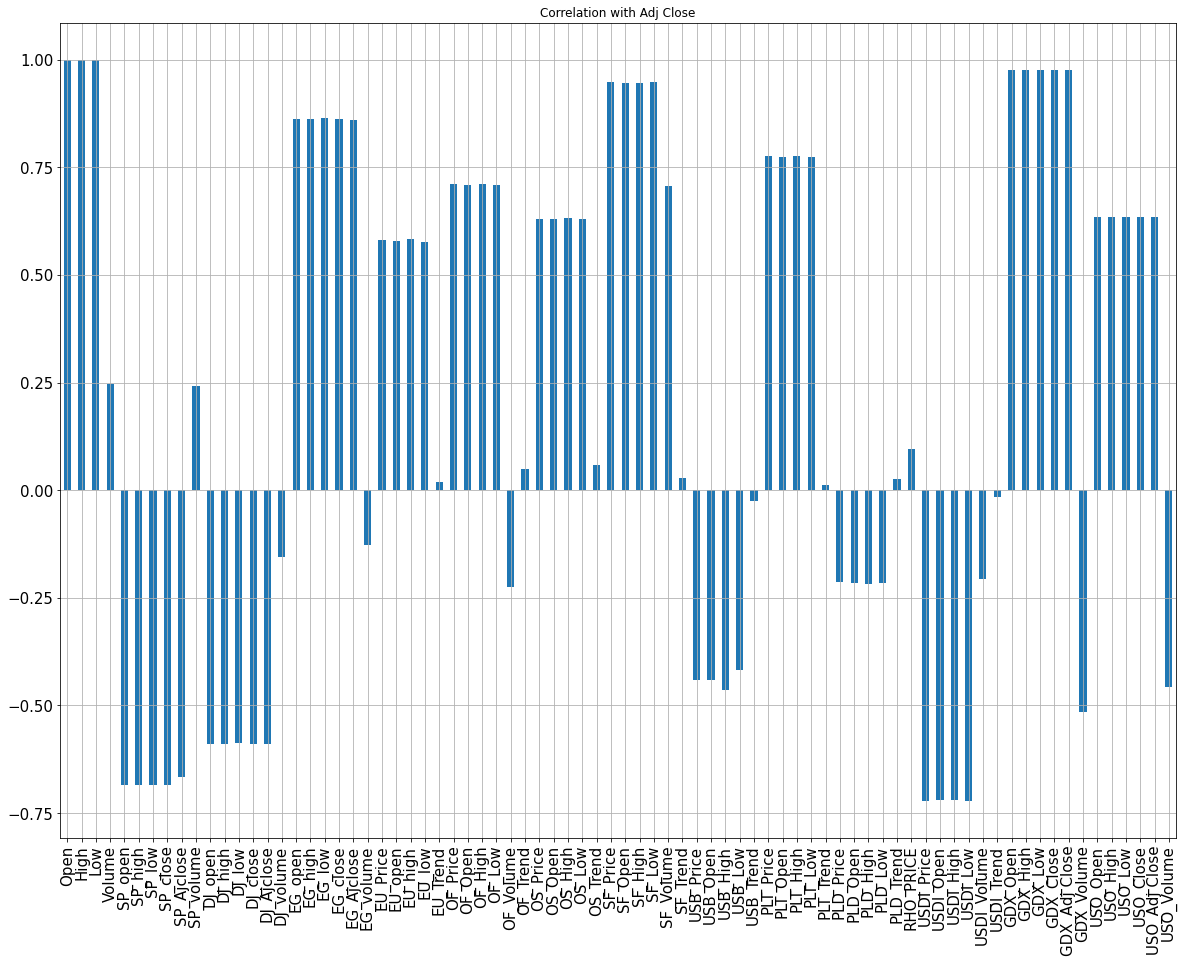

In [18]:
X.corrwith(gold_df['Adj Close']).plot.bar(title = 'Correlation with Adj Close', rot = 90, grid = True, figsize = (20,15), fontsize = 15)

In [19]:
correlation_matrix = gold_df.corr()
coeff = correlation_matrix['Adj Close'].sort_values(ascending = False)

In [20]:
posi_corr = coeff[coeff > 0]
posi_corr

Close            1.000000
Adj Close        1.000000
High             0.999535
Low              0.999532
Open             0.998976
GDX_Low          0.975561
GDX_Close        0.975459
GDX_High         0.975255
GDX_Adj Close    0.974980
GDX_Open         0.974824
SF_Low           0.947842
SF_Price         0.947420
SF_Open          0.945557
SF_High          0.945203
EG_low           0.863917
EG_open          0.862900
EG_close         0.862770
EG_high          0.861479
EG_Ajclose       0.859850
PLT_Price        0.775861
PLT_High         0.775481
PLT_Low          0.773993
PLT_Open         0.773760
OF_High          0.711334
OF_Price         0.710693
OF_Open          0.709096
OF_Low           0.708266
SF_Volume        0.706505
USO_Adj Close    0.635675
USO_Close        0.635675
USO_High         0.635311
USO_Open         0.635197
USO_Low          0.634732
OS_High          0.632001
OS_Price         0.630817
OS_Open          0.630046
OS_Low           0.629083
EU_high          0.582969
EU_Price    

In [21]:
nega_corr = coeff[coeff < 0]
nega_corr

USDI_Trend    -0.016641
USB_Trend     -0.025933
EG_volume     -0.126586
DJ_volume     -0.155526
USDI_Volume   -0.205954
PLD_Price     -0.213179
PLD_Low       -0.214919
PLD_Open      -0.216426
PLD_High      -0.217490
OF_Volume     -0.225436
USB_Low       -0.417352
USB_Open      -0.440822
USB_Price     -0.441347
USO_Volume    -0.456193
USB_High      -0.464116
GDX_Volume    -0.514616
DJ_low        -0.588157
DJ_Ajclose    -0.588411
DJ_close      -0.588411
DJ_high       -0.588778
DJ_open       -0.588800
SP_Ajclose    -0.666071
SP_low        -0.683750
SP_close      -0.684284
SP_open       -0.684618
SP_high       -0.684904
USDI_High     -0.720023
USDI_Open     -0.720140
USDI_Price    -0.721569
USDI_Low      -0.722078
Name: Adj Close, dtype: float64

In [22]:
def compute_macd(df, nslow = 26, nfast = 12):
    emaslow = df.ewm(span = nslow, min_periods = nslow, adjust = True, ignore_na = False).mean()
    emafast = df.ewm(span = nfast, min_periods = nfast, adjust = True, ignore_na = False).mean()
    diff = emafast - emaslow
    macd = diff.ewm(span = 9, min_periods = 9, adjust = True, ignore_na = False).mean()
    return diff, macd

def compute_rsi(df, periods = 14):
    dif = df.diff()
    up, down = dif.copy(), dif.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    rsi_up = up.ewm(com = periods, adjust = False).mean()
    rsi_down = down.ewm(com = periods, adjust = False).mean().abs()
    rsi = 100 - 100 / (1 + rsi_up / rsi_down)
    return rsi

def compute_sma(df, periods = 15):
    sma = df.rolling(window = periods, min_periods = periods, center = False).mean()
    return sma

def compute_bands(df, periods = 15):
    std = df.rolling(window = periods, min_periods = periods, center = False).std()
    sma = compute_sma(df)
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return upper_band, lower_band

def compute_std_dev(df, periods = 5):
    std_dev = df.rolling(periods).std()
    return std_dev

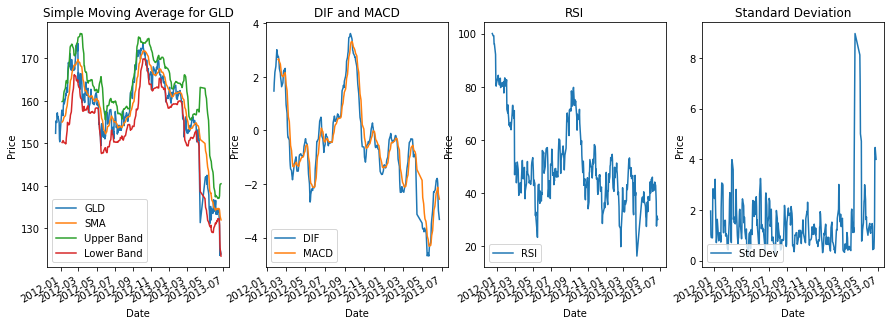

In [23]:
figure, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (15,5))

sma_gld = compute_sma(gld_adj_close) # computing the simple moving average for GLD

gld_adj_close[:365].plot(title = "Simple Moving Average for GLD", label = 'GLD', ax = axes[0])
sma_gld[:365].plot(label = 'SMA', ax = axes[0])

upper_band, lower_band = compute_bands(gld_adj_close) # calculating Bollinger Bands for GLD

upper_band[:365].plot(label = 'Upper Band', ax = axes[0])
lower_band[:365].plot(label = 'Lower Band', ax = axes[0])

dif, macd = compute_macd(gld_adj_close) # Calculating MACD for GLD

dif[:365].plot(title = 'DIF and MACD', label = 'DIF', ax = axes[1])
macd[:365].plot(label = 'MACD', ax = axes[1])

rsi = compute_rsi(gld_adj_close) # Calculating RSI for GLD
rsi[:365].plot(title = 'RSI', label = 'RSI', ax = axes[2])

std_dev = compute_std_dev(gld_adj_close) # Calculating Standard Deviation for GLD
std_dev[:365].plot(title = 'Standard Deviation', label = 'Std Dev', ax = axes[3])

open_close = gold_df.Open - gold_df.Close
high_low = gold_df.High - gold_df.Low

axes[0].set_ylabel('Price')
axes[1].set_ylabel('Price')
axes[2].set_ylabel('Price')
axes[3].set_ylabel('Price')

axes[0].legend(loc = 'lower left')
axes[1].legend(loc = 'lower left')
axes[2].legend(loc = 'lower left')
axes[3].legend(loc = 'lower left')


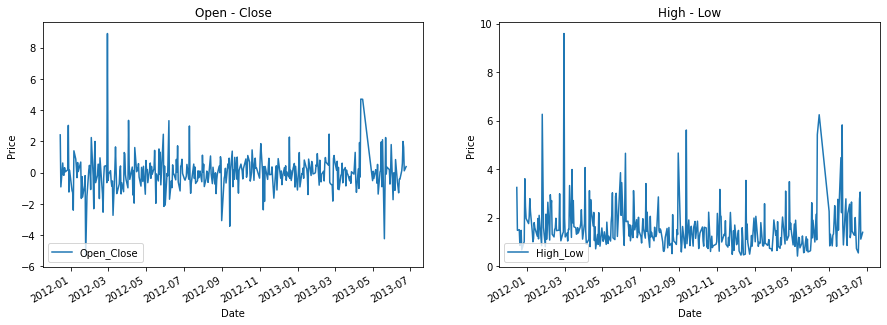

In [24]:
figure, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))

open_close = gold_df.Open - gold_df.Close
open_close[:365].plot(title = 'Open - Close', label = 'Open_Close', ax = axes[0])

high_low = gold_df.High - gold_df.Low
high_low[:365].plot(title = 'High - Low', label = "High_Low", ax = axes[1])

axes[0].set_ylabel('Price')
axes[1].set_ylabel('Price')

axes[0].legend(loc = 'lower left')
axes[1].legend(loc = 'lower left')

In [25]:
test_df = gold_df
test_df['SMA'] = sma_gld
test_df['Upper Band'] = upper_band
test_df['Lower Band'] = lower_band
test_df['DIF'] = dif
test_df['MACD'] = macd
test_df['RSI'] = rsi
test_df['Std Dev'] = std_dev
test_df['Open_Close'] = open_close
test_df['High_Low'] = high_low

test_df = test_df[33:] # Dropping first 33 rows as it has null values because technical indicators are introduced

target_adj_close = pd.DataFrame(test_df['Adj Close']) # Target Column

display(test_df.head())

,Open,High,Low,Close,Adj Close,Volume,SP_open,SP_high,SP_low,SP_close,...,USO_Volume,SMA,Upper Band,Lower Band,DIF,MACD,RSI,Std Dev,Open_Close,High_Low
Date,,,,,,,,,,,,,,,,,,,,,
2012-02-06,166.960007,167.679993,166.610001,167.179993,167.179993,8807400,133.979996,134.509995,133.830002,134.449997,...,6126100,165.198666,173.018365,157.378968,2.724443,2.641891,70.144545,1.562107,-0.219986,1.069992
2012-02-07,167.380005,170.089996,167.149994,169.699997,169.699997,11614300,134.169998,135.020004,133.639999,134.789993,...,10237000,165.894667,173.296304,158.493029,2.754381,2.667095,73.152763,1.594111,-2.319992,2.940002
2012-02-08,169.259995,169.960007,167.500000,168.500000,168.500000,10655500,134.860001,135.220001,134.309998,135.190002,...,9045800,166.428000,173.297467,159.558533,2.655845,2.664634,69.576023,1.575718,0.759995,2.460007
2012-02-09,170.009995,170.369995,167.669998,168.020004,168.020004,16085200,135.410004,135.589996,134.559998,135.360001,...,4663500,166.856000,173.217507,160.494493,2.511947,2.631843,68.148015,0.965153,1.989991,2.699997
2012-02-10,166.490005,167.639999,166.330002,167.139999,167.139999,10326800,134.160004,134.470001,133.839996,134.360001,...,6008600,167.250666,172.795817,161.705515,2.303734,2.562404,65.507009,1.059963,-0.649994,1.309997


In [26]:
test_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'SP_open',
       'SP_high', 'SP_low', 'SP_close', 'SP_Ajclose', 'SP_volume', 'DJ_open',
       'DJ_high', 'DJ_low', 'DJ_close', 'DJ_Ajclose', 'DJ_volume', 'EG_open',
       'EG_high', 'EG_low', 'EG_close', 'EG_Ajclose', 'EG_volume', 'EU_Price',
       'EU_open', 'EU_high', 'EU_low', 'EU_Trend', 'OF_Price', 'OF_Open',
       'OF_High', 'OF_Low', 'OF_Volume', 'OF_Trend', 'OS_Price', 'OS_Open',
       'OS_High', 'OS_Low', 'OS_Trend', 'SF_Price', 'SF_Open', 'SF_High',
       'SF_Low', 'SF_Volume', 'SF_Trend', 'USB_Price', 'USB_Open', 'USB_High',
       'USB_Low', 'USB_Trend', 'PLT_Price', 'PLT_Open', 'PLT_High', 'PLT_Low',
       'PLT_Trend', 'PLD_Price', 'PLD_Open', 'PLD_High', 'PLD_Low',
       'PLD_Trend', 'RHO_PRICE', 'USDI_Price', 'USDI_Open', 'USDI_High',
       'USDI_Low', 'USDI_Volume', 'USDI_Trend', 'GDX_Open', 'GDX_High',
       'GDX_Low', 'GDX_Close', 'GDX_Adj Close', 'GDX_Volume', 'USO_Open',
       'USO_High', 'USO

In [27]:
feature_cols = ['Open', 'High', 'Low', 'Volume', 'SP_open',
       'SP_high', 'SP_low', 'SP_Ajclose', 'SP_volume', 'DJ_open',
       'DJ_high', 'DJ_low', 'DJ_Ajclose', 'DJ_volume', 'EG_open',
       'EG_high', 'EG_low', 'EG_Ajclose', 'EG_volume', 'EU_Price',
       'EU_open', 'EU_high', 'EU_low', 'EU_Trend', 'OF_Price', 'OF_Open',
       'OF_High', 'OF_Low', 'OF_Volume', 'OF_Trend', 'OS_Price', 'OS_Open',
       'OS_High', 'OS_Low', 'OS_Trend', 'SF_Price', 'SF_Open', 'SF_High',
       'SF_Low', 'SF_Volume', 'SF_Trend', 'USB_Price', 'USB_Open', 'USB_High',
       'USB_Low', 'USB_Trend', 'PLT_Price', 'PLT_Open', 'PLT_High', 'PLT_Low',
       'PLT_Trend', 'PLD_Price', 'PLD_Open', 'PLD_High', 'PLD_Low',
       'PLD_Trend', 'RHO_PRICE', 'USDI_Price', 'USDI_Open', 'USDI_High',
       'USDI_Low', 'USDI_Volume', 'USDI_Trend', 'GDX_Open', 'GDX_High',
       'GDX_Low', 'GDX_Close', 'GDX_Adj Close', 'GDX_Volume', 'USO_Open',
       'USO_High', 'USO_Low', 'USO_Close', 'USO_Adj Close', 'USO_Volume',
       'SMA', 'Upper Band', 'Lower Band', 'DIF', 'MACD', 'RSI', 'Std Dev',
       'Open_Close', 'High_Low']

In [28]:
feat_minmax_trans_data = MinMaxScaler().fit_transform(test_df[feature_cols])
feat_minmax_transform = pd.DataFrame(columns = feature_cols, data = feat_minmax_trans_data, index = test_df.index)
feat_minmax_transform.head()

,Open,High,Low,Volume,SP_open,SP_high,SP_low,SP_Ajclose,SP_volume,DJ_open,...,USO_Volume,SMA,Upper Band,Lower Band,DIF,MACD,RSI,Std Dev,Open_Close,High_Low
Date,,,,,,,,,,,,,,,,,,,,,
2012-02-06,0.913669,0.912561,0.913193,0.079151,0.037098,0.034927,0.040627,0.028113,0.166542,0.051563,...,0.046608,0.906189,0.961240,0.821988,0.893394,0.911893,0.807275,0.167603,0.415010,0.091684
2012-02-07,0.919480,0.945539,0.920622,0.109560,0.038247,0.038015,0.039473,0.029765,0.224602,0.050453,...,0.084243,0.916193,0.965092,0.837893,0.896986,0.915193,0.852413,0.171198,0.280308,0.291045
2012-02-08,0.945490,0.943760,0.925437,0.099173,0.042423,0.039225,0.043542,0.031707,0.232599,0.051907,...,0.073338,0.923859,0.965108,0.853105,0.885164,0.914871,0.798744,0.169132,0.477870,0.239873
2012-02-09,0.955866,0.949370,0.927775,0.157998,0.045752,0.041465,0.045060,0.032533,0.251876,0.053171,...,0.033218,0.930011,0.964000,0.866467,0.867900,0.910578,0.777317,0.100533,0.556766,0.265458
2012-02-10,0.907167,0.912014,0.909341,0.095612,0.038187,0.034685,0.040687,0.027676,0.292146,0.053519,...,0.045532,0.935684,0.958155,0.883757,0.842920,0.901486,0.737688,0.111185,0.387428,0.117271


In [29]:
display(feat_minmax_transform.head())
print('Shape of features: ', feat_minmax_transform.shape)
print('Shape of target: ', target_adj_close.shape)

target_adj_close = target_adj_close.shift(-1) # to predict the target on the (n+1)th day
validation_yvalue = target_adj_close[-85:-1]
target_adj_close = target_adj_close[:-85]

validation_xvalue = feat_minmax_transform[-85:-1] # taking last 85 rows to be as validation set
feat_minmax_transform = feat_minmax_transform[:-85]
display(validation_xvalue.tail())
display(validation_yvalue.tail())

print('\n AFTER PROCESS \n')
print('Shape of features: ', feat_minmax_transform.shape)
print('Shape of target: ', target_adj_close.shape)
display(target_adj_close.tail())


,Open,High,Low,Volume,SP_open,SP_high,SP_low,SP_Ajclose,SP_volume,DJ_open,...,USO_Volume,SMA,Upper Band,Lower Band,DIF,MACD,RSI,Std Dev,Open_Close,High_Low
Date,,,,,,,,,,,,,,,,,,,,,
2012-02-06,0.913669,0.912561,0.913193,0.079151,0.037098,0.034927,0.040627,0.028113,0.166542,0.051563,...,0.046608,0.906189,0.961240,0.821988,0.893394,0.911893,0.807275,0.167603,0.415010,0.091684
2012-02-07,0.919480,0.945539,0.920622,0.109560,0.038247,0.038015,0.039473,0.029765,0.224602,0.050453,...,0.084243,0.916193,0.965092,0.837893,0.896986,0.915193,0.852413,0.171198,0.280308,0.291045
2012-02-08,0.945490,0.943760,0.925437,0.099173,0.042423,0.039225,0.043542,0.031707,0.232599,0.051907,...,0.073338,0.923859,0.965108,0.853105,0.885164,0.914871,0.798744,0.169132,0.477870,0.239873
2012-02-09,0.955866,0.949370,0.927775,0.157998,0.045752,0.041465,0.045060,0.032533,0.251876,0.053171,...,0.033218,0.930011,0.964000,0.866467,0.867900,0.910578,0.777317,0.100533,0.556766,0.265458
2012-02-10,0.907167,0.912014,0.909341,0.095612,0.038187,0.034685,0.040687,0.027676,0.292146,0.053519,...,0.045532,0.935684,0.958155,0.883757,0.842920,0.901486,0.737688,0.111185,0.387428,0.117271


Shape of features:  (1685, 84)
Shape of target:  (1685, 1)


,Open,High,Low,Volume,SP_open,SP_high,SP_low,SP_Ajclose,SP_volume,DJ_open,...,USO_Volume,SMA,Upper Band,Lower Band,DIF,MACD,RSI,Std Dev,Open_Close,High_Low
Date,,,,,,,,,,,,,,,,,,,,,
2018-12-21,0.252767,0.249863,0.252304,0.131396,0.719499,0.732264,0.685249,0.721173,0.474541,0.731087,...,0.346662,0.221370,0.217009,0.228105,0.658641,0.648503,0.687759,0.071990,0.459268,0.050107
2018-12-24,0.258024,0.262042,0.266061,0.089215,0.672900,0.678571,0.650574,0.685607,0.249183,0.693452,...,0.188254,0.225663,0.221905,0.231591,0.673309,0.655308,0.771343,0.103731,0.400256,0.038380
2018-12-26,0.272551,0.273810,0.266061,0.138587,0.654321,0.710896,0.647477,0.751818,0.397651,0.662258,...,0.365682,0.228778,0.225424,0.234153,0.680140,0.662243,0.728779,0.105509,0.490699,0.130064
2018-12-27,0.271859,0.272441,0.273903,0.112378,0.694263,0.723668,0.679055,0.762387,0.330444,0.714615,...,0.325400,0.232083,0.233069,0.232846,0.692906,0.670576,0.782400,0.071859,0.429121,0.058636
2018-12-28,0.275042,0.274904,0.281882,0.058103,0.736686,0.742494,0.724540,0.760598,0.261258,0.754292,...,0.199288,0.235840,0.241125,0.232010,0.706157,0.680136,0.808642,0.092629,0.412444,0.015992


,Adj Close
Date,
2018-12-21,120.019997
2018-12-24,119.660004
2018-12-26,120.570000
2018-12-27,121.059998
2018-12-28,121.250000



 AFTER PROCESS 

Shape of features:  (1600, 84)
Shape of target:  (1600, 1)


,Adj Close
Date,
2018-08-21,113.269997
2018-08-22,112.199997
2018-08-23,114.160004
2018-08-24,114.589996
2018-08-27,113.680000


In [30]:
for train_index, test_index in TimeSeriesSplit(n_splits = 10).split(feat_minmax_transform):
    x_train, x_test = feat_minmax_transform[:len(train_index)], feat_minmax_transform[len(train_index):(len(train_index) + len(test_index))]
    y_train, y_test = target_adj_close[:len(train_index)].values.ravel(), target_adj_close[len(train_index):(len(train_index) + len(test_index))].values.ravel()

In [31]:
y_train=np.reshape(y_train, (-1,1))
y_val=np.reshape(y_test, (-1,1))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
print(scaler_x.fit(x_train))
xtrain_scale=scaler_x.transform(x_train)
print(scaler_x.fit(x_test))
xval_scale=scaler_x.transform(x_test)
print(scaler_y.fit(y_train))
ytrain_scale=scaler_y.transform(y_train)
print(scaler_y.fit(y_val))
yval_scale=scaler_y.transform(y_val)

MinMaxScaler()
MinMaxScaler()
MinMaxScaler()
MinMaxScaler()


In [32]:
from keras.models import Sequential
from keras.layers import Activation, Dense
model = Sequential()

model.add(Dense(1,input_dim=84, kernel_initializer='normal', activation='relu'))
model.add(Dense(2670, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 85        
_________________________________________________________________
dense_1 (Dense)              (None, 2670)              5340      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2671      
Total params: 8,096
Trainable params: 8,096
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.compile(loss='mse', optimizer='sgd', metrics=['mse','mae'])
history=model.fit(xtrain_scale, ytrain_scale, epochs=30, batch_size=150, verbose=1, validation_split=0.2)
predictions = model.predict(xval_scale)

Epoch 1/30
8/8 [==============================] - 0s 53ms/step - loss: 0.1933 - mse: 0.1933 - mae: 0.3531 - val_loss: 0.0293 - val_mse: 0.0293 - val_mae: 0.1600
Epoch 2/30
8/8 [==============================] - 0s 11ms/step - loss: 0.1305 - mse: 0.1305 - mae: 0.2668 - val_loss: 0.0116 - val_mse: 0.0116 - val_mae: 0.0945
Epoch 3/30
8/8 [==============================] - 0s 11ms/step - loss: 0.0955 - mse: 0.0955 - mae: 0.2148 - val_loss: 0.0052 - val_mse: 0.0052 - val_mae: 0.0584
Epoch 4/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0756 - mse: 0.0756 - mae: 0.1899 - val_loss: 0.0044 - val_mse: 0.0044 - val_mae: 0.0504
Epoch 5/30
8/8 [==============================] - 0s 11ms/step - loss: 0.0645 - mse: 0.0645 - mae: 0.1821 - val_loss: 0.0057 - val_mse: 0.0057 - val_mae: 0.0586
Epoch 6/30
8/8 [==============================] - 0s 12ms/step - loss: 0.0580 - mse: 0.0580 - mae: 0.1812 - val_loss: 0.0074 - val_mse: 0.0074 - val_mae: 0.0682
Epoch 7/30
8/8 [===================

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


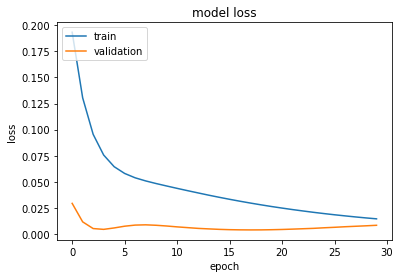

In [34]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [35]:
predictions = scaler_y.inverse_transform(predictions)
predictions

array([[121.54929 ],
       [120.781   ],
       [121.41019 ],
       [122.014534],
       [121.5556  ],
       [121.28763 ],
       [120.9086  ],
       [119.821075],
       [120.00137 ],
       [118.864716],
       [119.15898 ],
       [119.12063 ],
       [119.73289 ],
       [119.91475 ],
       [120.94011 ],
       [120.15141 ],
       [118.67555 ],
       [119.38867 ],
       [119.14507 ],
       [120.98783 ],
       [119.41047 ],
       [119.26953 ],
       [118.590866],
       [119.252754],
       [120.32653 ],
       [120.470924],
       [119.678055],
       [119.01892 ],
       [119.45059 ],
       [119.391945],
       [119.40357 ],
       [119.718506],
       [119.19071 ],
       [118.9594  ],
       [119.36646 ],
       [119.05795 ],
       [120.59322 ],
       [119.877174],
       [120.960495],
       [121.24745 ],
       [121.65244 ],
       [119.77196 ],
       [121.009056],
       [120.72537 ],
       [120.04978 ],
       [120.24431 ],
       [120.175125],
       [119.3

In [36]:
! pip install statsmodels

In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS

In [38]:
lm_sm = OLS(y_train, x_train).fit()
y_pred = pd.DataFrame()   # dataframe for predictions vs actual y-values
y_pred['predictions'] = lm_sm.predict(x_test)

# Print this directly
print(lm_sm.predict(x_test))

Date
2018-01-30    126.550421
2018-01-31    127.919523
2018-02-01    127.737351
2018-02-02    126.200960
2018-02-05    126.197587
                 ...    
2018-08-21    113.115723
2018-08-22    113.641611
2018-08-23    112.487813
2018-08-24    114.538950
2018-08-27    115.106361
Length: 145, dtype: float64


In [39]:
print(y_pred)

            predictions
Date                   
2018-01-30   126.550421
2018-01-31   127.919523
2018-02-01   127.737351
2018-02-02   126.200960
2018-02-05   126.197587
...                 ...
2018-08-21   113.115723
2018-08-22   113.641611
2018-08-23   112.487813
2018-08-24   114.538950
2018-08-27   115.106361

[145 rows x 1 columns]


In [40]:
y_test

array([127.650002, 128.070007, 126.389999, 126.709999, 125.379997,
       124.790001, 124.980003, 124.769997, 125.370003, 126.080002,
       128.229996, 128.380005, 127.959999, 126.239998, 125.660004,
       126.300003, 126.139999, 126.449997, 125.129997, 125.      ,
       124.720001, 125.389999, 125.18    , 126.529999, 125.720001,
       125.419998, 125.540001, 125.540001, 125.779999, 125.699997,
       124.900002, 124.599998, 124.870003, 124.309998, 126.480003,
       125.980003, 127.610001, 128.279999, 127.489998, 125.730003,
       125.790001, 127.260002, 126.300003, 126.449997, 125.800003,
       126.389999, 126.82    , 127.120003, 128.110001, 126.620003,
       127.449997, 127.629997, 127.75    , 127.849998, 127.599998,
       126.629997, 125.620003, 126.230003, 125.410004, 124.970001,
       125.5     , 124.589996, 123.709999, 123.650002, 124.279999,
       124.540001, 124.57    , 124.589996, 124.330002, 125.18    ,
       125.      , 124.489998, 122.480003, 122.290001, 122.360

In [41]:
######ttest and ptest

from scipy import stats

t_value,p_value=stats.ttest_ind(y_pred,y_test)

print('T-Test: %.3f' % t_value)
print('P-Test: %.3f' % p_value)

T-Test: -0.226
P-Test: 0.821


In [42]:
#####Accuracy for regression is calculated as r2
from sklearn.metrics import r2_score
r2 =r2_score(y_pred,y_test)
print('r2_score: %.3f' % r2)

r2_score: 0.958


In [53]:
######pearson coefficient
from scipy.stats import pearsonr
corr, _ = pearsonr(y_test, y_pred)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.984


In [44]:
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(y_test, y_pred, squared=False)
rms

0.8867774922619979

In [54]:
 from sklearn.metrics import f1_score
 f1_score(y_true, y_pred, average=None)

NameError: name 'y_true' is not defined

In [ ]:
model = Sequential()
model.add(Dense(1, input_dim=84, kernel_initializer='normal', activation='elu'))
model.add(Dense(2670, activation='relu'))
model.add(Dense(1500, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
history=model.fit(xtrain_scale, ytrain_scale, epochs=30, batch_size=150, verbose=1, validation_split=0.2)
predictions = model.predict(xval_scale)

In [ ]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats

In [ ]:
a=stats.zscore(predictions)

In [ ]:
a